# Model Evaluation
The following notebook performs measures various metrics involving the models against the provided ground-truth data.
This notebook is meant to be used as a prototype workbench for developing core code for model performance evaluation and comparison.

In our evaluation pipeline, we closely follow the result analysis performed by Gabere et. al.

In [2]:
import math
import numpy as np
import seaborn as sns
import modin.pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

Process STDOUT and STDERR is being redirected to /tmp/raylogs/.
Waiting for redis server at 127.0.0.1:26397 to respond...
Waiting for redis server at 127.0.0.1:14520 to respond...
Starting the Plasma object store with 6.00 GB memory.


In [4]:
# Application Hyperparameters
DATA_ROOT = '../data/out/data2.fasta.txt/'
# SERVERS = ['ADAM_HMM', 'ADAM_SVM', 'AMPA', 'CAMPR3-ANN', 'CAMPR3-DA', 'CAMPR3-RF', 'CAMPR3-SVM']
SERVERS = ['ADAM_HMM', 'ADAM_SVM', 'AMPA', 'CMPR3_ANN', 'CMPR3_DA', 'CMPR3_RF']
DATASET = ['A', 'D'] # A for AMP3 and D for DAMPD
REVERSE = ['', 'R', 'R1', 'R2', 'R3']

## Load Dataset

In [5]:
data = {}
for s in SERVERS:
    raw = pd.read_csv(DATA_ROOT + s + '.csv')
    data[s] = {}
    for d in DATASET:
        data[s][d] = {}
        for r in REVERSE:
            # Append True Values
            data[s][d][r] = raw[raw.AMPLabel == 1][raw.PepID.str.contains('R') == False]
            
            # Filter Out by
            if r == '':
                data[s][d][r] = data[s][d][r].append(raw[raw.AMPLabel == 0][raw.PepID.str.contains('R') == False])
            elif r == 'R':
                data[s][d][r] = data[s][d][r].append(raw[raw.PepID.str.contains('R') == True][raw.PepID.str.contains('R1') == False][raw.PepID.str.contains('R2') == False][raw.PepID.str.contains('R3') == False])
            else:
                data[s][d][r] = data[s][d][r].append(raw[raw.PepID.str.contains(r)])
            
            print(s + ' ['+d+r+']' + ' : ' + str(data[s][d][r].size) + ' RECORDS')
        print('-'*30)

ADAM_HMM [A] : 81354 RECORDS
ADAM_HMM [AR] : 81354 RECORDS
ADAM_HMM [AR1] : 81354 RECORDS
ADAM_HMM [AR2] : 81354 RECORDS
ADAM_HMM [AR3] : 81354 RECORDS
------------------------------
ADAM_HMM [D] : 81354 RECORDS
ADAM_HMM [DR] : 81354 RECORDS
ADAM_HMM [DR1] : 81354 RECORDS
ADAM_HMM [DR2] : 81354 RECORDS
ADAM_HMM [DR3] : 81354 RECORDS
------------------------------
ADAM_SVM [A] : 81354 RECORDS
ADAM_SVM [AR] : 81354 RECORDS
ADAM_SVM [AR1] : 81354 RECORDS
ADAM_SVM [AR2] : 81354 RECORDS
ADAM_SVM [AR3] : 81354 RECORDS
------------------------------
ADAM_SVM [D] : 81354 RECORDS
ADAM_SVM [DR] : 81354 RECORDS
ADAM_SVM [DR1] : 81354 RECORDS
ADAM_SVM [DR2] : 81354 RECORDS
ADAM_SVM [DR3] : 81354 RECORDS
------------------------------
AMPA [A] : 81354 RECORDS
AMPA [AR] : 81354 RECORDS
AMPA [AR1] : 81354 RECORDS
AMPA [AR2] : 81354 RECORDS
AMPA [AR3] : 81354 RECORDS
------------------------------
AMPA [D] : 81354 RECORDS
AMPA [DR] : 81354 RECORDS
AMPA [DR1] : 81354 RECORDS
AMPA [DR2] : 81354 RECORDS


In [6]:
# Filter -999 Values
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            pre_filter = data[s][d][r].size
            data[s][d][r] = data[s][d][r].query('PredLabel != -999')
            print(s + ' ['+d+r+']' + ' (POST-FILTERED): ' + str(data[s][d][r].size) + ' RECORDS ' + '('+ str(pre_filter - data[s][d][r].size) +' FILTERED)')
        print('-'*75)

/usr/local/lib/python3.6/dist-packages/modin/pandas/dataframe.py:2901: UserWarning: User-defined function verification with DataFrame dtypes is still under development. Should be fully functional in a future release.
  UserWarning,


ADAM_HMM [A] (POST-FILTERED): 81240 RECORDS (114 FILTERED)
ADAM_HMM [AR] (POST-FILTERED): 81228 RECORDS (126 FILTERED)
ADAM_HMM [AR1] (POST-FILTERED): 81240 RECORDS (114 FILTERED)
ADAM_HMM [AR2] (POST-FILTERED): 81252 RECORDS (102 FILTERED)
ADAM_HMM [AR3] (POST-FILTERED): 81252 RECORDS (102 FILTERED)
---------------------------------------------------------------------------
ADAM_HMM [D] (POST-FILTERED): 81240 RECORDS (114 FILTERED)
ADAM_HMM [DR] (POST-FILTERED): 81228 RECORDS (126 FILTERED)
ADAM_HMM [DR1] (POST-FILTERED): 81240 RECORDS (114 FILTERED)
ADAM_HMM [DR2] (POST-FILTERED): 81252 RECORDS (102 FILTERED)
ADAM_HMM [DR3] (POST-FILTERED): 81252 RECORDS (102 FILTERED)
---------------------------------------------------------------------------
ADAM_SVM [A] (POST-FILTERED): 81144 RECORDS (210 FILTERED)
ADAM_SVM [AR] (POST-FILTERED): 81180 RECORDS (174 FILTERED)
ADAM_SVM [AR1] (POST-FILTERED): 81192 RECORDS (162 FILTERED)
ADAM_SVM [AR2] (POST-FILTERED): 81204 RECORDS (150 FILTERED)
ADA

## Threshold Based Metrics

### Confusion Matrix

In [7]:
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            print('[' + s + ' ['+d+r+']' + ']')
            con_mat = confusion_matrix(data[s][d][r]['AMPLabel'], data[s][d][r]['PredLabel'])
            print(str(con_mat) + '\n')
            print('True Positive:\t' + str(con_mat[0][0]))
            print('False Positive:\t' + str(con_mat[0][1]))
            print('False Negative:\t' + str(con_mat[1][0]))
            print('True Negative:\t' + str(con_mat[1][1]))
            print('-'*40)
    print('='* 40)

[ADAM_HMM [A]]
[[7189 4102]
 [ 229 2020]]

True Positive:	7189
False Positive:	4102
False Negative:	229
True Negative:	2020
----------------------------------------
[ADAM_HMM [AR]]
[[7192 4097]
 [ 229 2020]]

True Positive:	7192
False Positive:	4097
False Negative:	229
True Negative:	2020
----------------------------------------
[ADAM_HMM [AR1]]
[[7194 4097]
 [ 229 2020]]

True Positive:	7194
False Positive:	4097
False Negative:	229
True Negative:	2020
----------------------------------------
[ADAM_HMM [AR2]]
[[7196 4097]
 [ 229 2020]]

True Positive:	7196
False Positive:	4097
False Negative:	229
True Negative:	2020
----------------------------------------
[ADAM_HMM [AR3]]
[[7196 4097]
 [ 229 2020]]

True Positive:	7196
False Positive:	4097
False Negative:	229
True Negative:	2020
----------------------------------------
[ADAM_HMM [D]]
[[7189 4102]
 [ 229 2020]]

True Positive:	7189
False Positive:	4102
False Negative:	229
True Negative:	2020
----------------------------------------
[AD

[[9123 2168]
 [ 120 2129]]

True Positive:	9123
False Positive:	2168
False Negative:	120
True Negative:	2129
----------------------------------------
[CMPR3_RF [AR1]]
[[9130 2161]
 [ 120 2129]]

True Positive:	9130
False Positive:	2161
False Negative:	120
True Negative:	2129
----------------------------------------
[CMPR3_RF [AR2]]
[[9155 2136]
 [ 120 2129]]

True Positive:	9155
False Positive:	2136
False Negative:	120
True Negative:	2129
----------------------------------------
[CMPR3_RF [AR3]]
[[9145 2146]
 [ 120 2129]]

True Positive:	9145
False Positive:	2146
False Negative:	120
True Negative:	2129
----------------------------------------
[CMPR3_RF [D]]
[[9126 2165]
 [ 120 2129]]

True Positive:	9126
False Positive:	2165
False Negative:	120
True Negative:	2129
----------------------------------------
[CMPR3_RF [DR]]
[[9123 2168]
 [ 120 2129]]

True Positive:	9123
False Positive:	2168
False Negative:	120
True Negative:	2129
----------------------------------------
[CMPR3_RF [DR1]]
[

In [8]:
print('Classification Report')

for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            print('['+s + ' ['+d+r+']'+']')
            print(classification_report(data[s][d][r]['AMPLabel'], data[s][d][r]['PredLabel'], [0, 1]))
            print('='*40)

Classification Report
[ADAM_HMM [A]]
              precision    recall  f1-score   support

           0       0.97      0.64      0.77     11291
           1       0.33      0.90      0.48      2249

   micro avg       0.68      0.68      0.68     13540
   macro avg       0.65      0.77      0.63     13540
weighted avg       0.86      0.68      0.72     13540

[ADAM_HMM [AR]]
              precision    recall  f1-score   support

           0       0.97      0.64      0.77     11289
           1       0.33      0.90      0.48      2249

   micro avg       0.68      0.68      0.68     13538
   macro avg       0.65      0.77      0.63     13538
weighted avg       0.86      0.68      0.72     13538

[ADAM_HMM [AR1]]
              precision    recall  f1-score   support

           0       0.97      0.64      0.77     11291
           1       0.33      0.90      0.48      2249

   micro avg       0.68      0.68      0.68     13540
   macro avg       0.65      0.77      0.63     13540
weig

              precision    recall  f1-score   support

           0       0.88      0.89      0.88     11264
           1       0.40      0.38      0.39      2238

   micro avg       0.80      0.80      0.80     13502
   macro avg       0.64      0.63      0.64     13502
weighted avg       0.80      0.80      0.80     13502

[AMPA [AR3]]
              precision    recall  f1-score   support

           0       0.88      0.89      0.88     11273
           1       0.41      0.38      0.40      2238

   micro avg       0.81      0.81      0.81     13511
   macro avg       0.64      0.64      0.64     13511
weighted avg       0.80      0.81      0.80     13511

[AMPA [D]]
              precision    recall  f1-score   support

           0       0.88      0.89      0.88     11274
           1       0.41      0.38      0.40      2238

   micro avg       0.81      0.81      0.81     13512
   macro avg       0.64      0.64      0.64     13512
weighted avg       0.80      0.81      0.80     13

              precision    recall  f1-score   support

           0       0.97      0.78      0.87     11291
           1       0.45      0.88      0.59      2249

   micro avg       0.80      0.80      0.80     13540
   macro avg       0.71      0.83      0.73     13540
weighted avg       0.88      0.80      0.82     13540

[CMPR3_DA [DR3]]
              precision    recall  f1-score   support

           0       0.97      0.78      0.87     11291
           1       0.45      0.88      0.59      2249

   micro avg       0.80      0.80      0.80     13540
   macro avg       0.71      0.83      0.73     13540
weighted avg       0.88      0.80      0.82     13540

[CMPR3_RF [A]]
              precision    recall  f1-score   support

           0       0.99      0.81      0.89     11291
           1       0.50      0.95      0.65      2249

   micro avg       0.83      0.83      0.83     13540
   macro avg       0.74      0.88      0.77     13540
weighted avg       0.91      0.83      0.8

### ROC/AUC Curve

#### Total ROC/AUC Score

In [9]:
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            print(s + ' ['+d+r+']' + ' SCORE:\t'+str(roc_auc_score(data[s][d][r]['AMPLabel'], data[s][d][r]['PredScore'])))
        print('-'*30)

ADAM_HMM [A] SCORE:	0.7674393827166279
ADAM_HMM [AR] SCORE:	0.767628655619267
ADAM_HMM [AR1] SCORE:	0.7676607980031392
ADAM_HMM [AR2] SCORE:	0.767692929002124
ADAM_HMM [AR3] SCORE:	0.767692929002124
------------------------------
ADAM_HMM [D] SCORE:	0.7674393827166279
ADAM_HMM [DR] SCORE:	0.767628655619267
ADAM_HMM [DR1] SCORE:	0.7676607980031392
ADAM_HMM [DR2] SCORE:	0.767692929002124
ADAM_HMM [DR3] SCORE:	0.767692929002124
------------------------------
ADAM_SVM [A] SCORE:	0.7563565141240906
ADAM_SVM [AR] SCORE:	0.7544143562764952
ADAM_SVM [AR1] SCORE:	0.7544464358975971
ADAM_SVM [AR2] SCORE:	0.7544785041560419
ADAM_SVM [AR3] SCORE:	0.7544945340261543
------------------------------
ADAM_SVM [D] SCORE:	0.7563565141240906
ADAM_SVM [DR] SCORE:	0.7544143562764952
ADAM_SVM [DR1] SCORE:	0.7544464358975971
ADAM_SVM [DR2] SCORE:	0.7544785041560419
ADAM_SVM [DR3] SCORE:	0.7544945340261543
------------------------------
AMPA [A] SCORE:	0.6425563900774961
AMPA [AR] SCORE:	0.6433266289380889
AMP

In [10]:
# Plot ROC/AUC
def plot_roc(name, d, r):
    plt.title(name + r + ' ROC')
    for s in SERVERS:
        fpr, tpr, threshold = roc_curve(data[s][d][r]['AMPLabel'], data[s][d][r]['PredScore'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label = s + ': %0.2f' % roc_auc)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

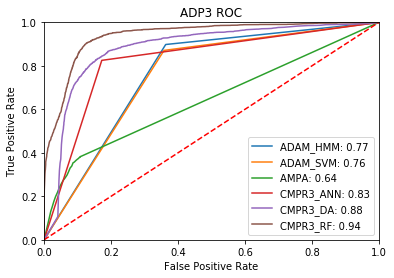

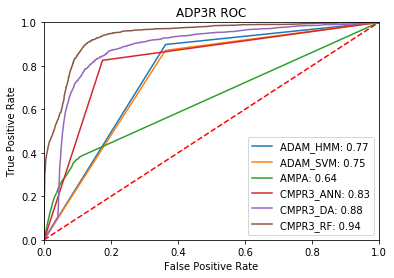

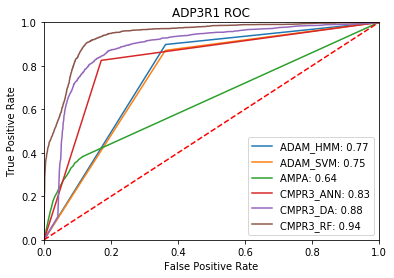

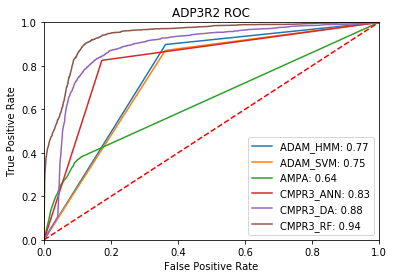

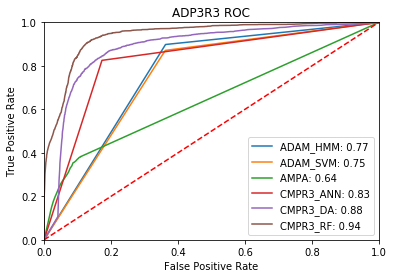

In [11]:
for r in REVERSE:
    plot_roc('ADP3', 'A', r)

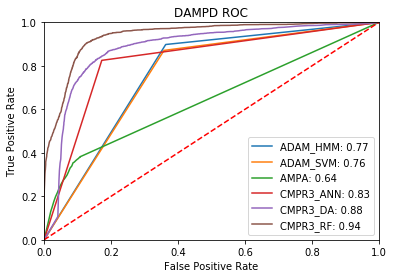

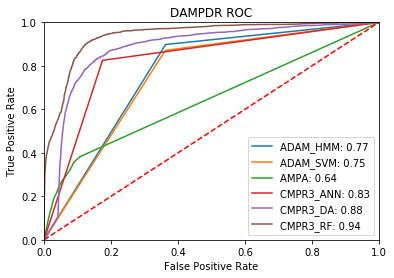

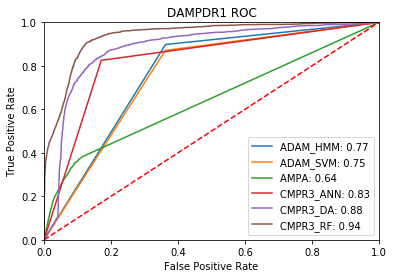

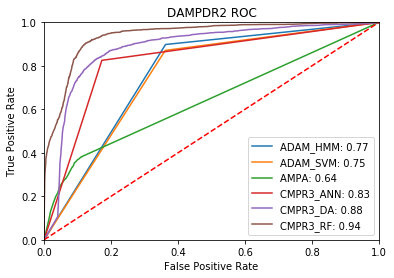

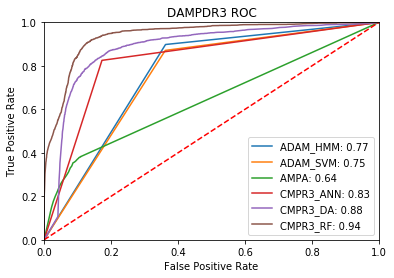

In [12]:
for r in REVERSE:
    plot_roc('DAMPD', 'D', r)

## Feature Dependence Analysis

### Length vs Prediction Probability

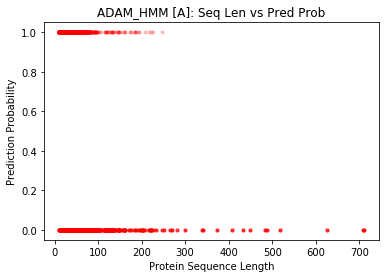

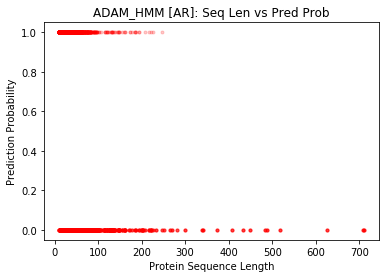

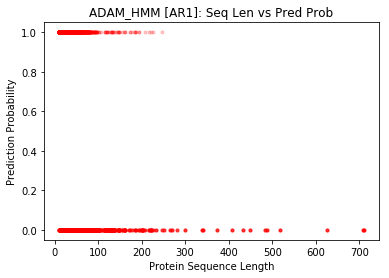

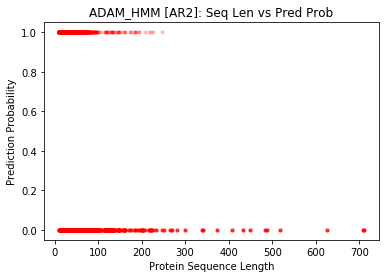

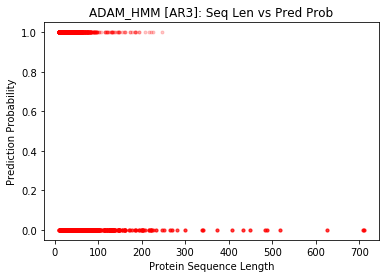

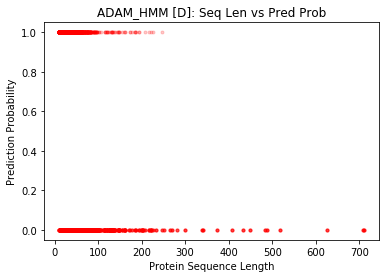

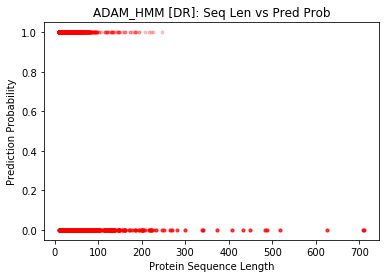

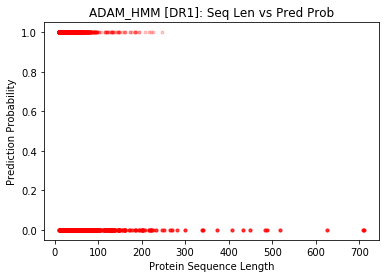

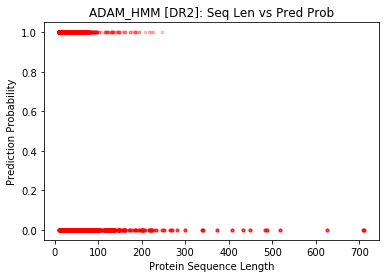

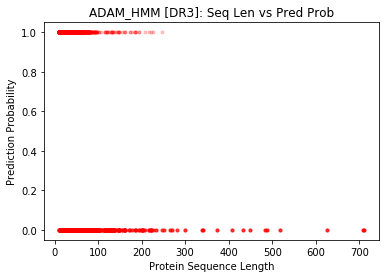

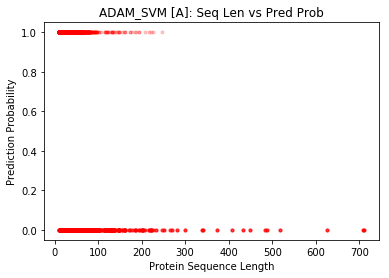

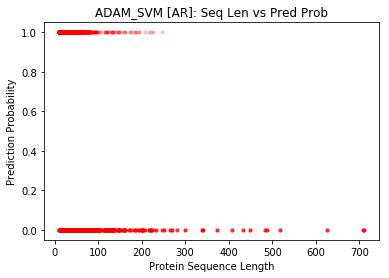

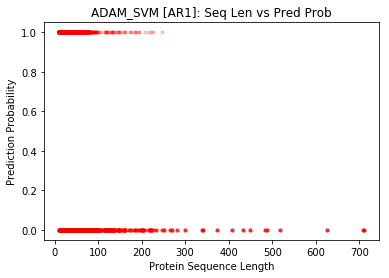

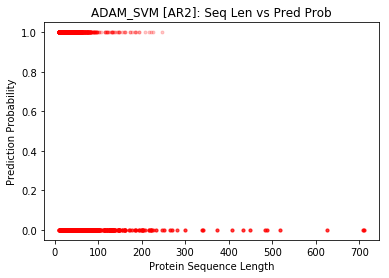

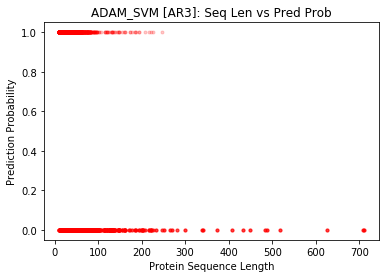

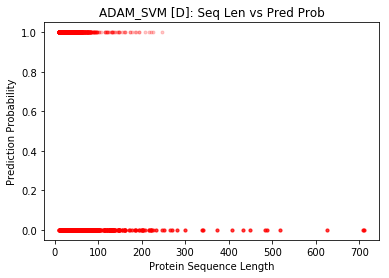

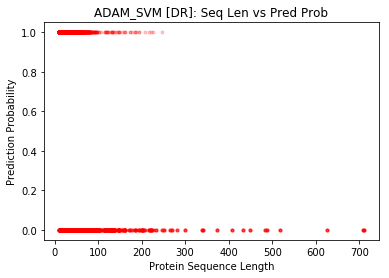

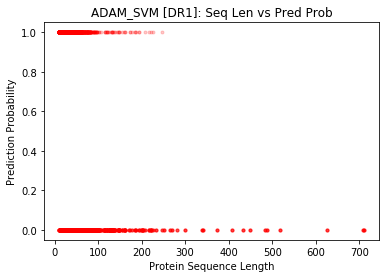

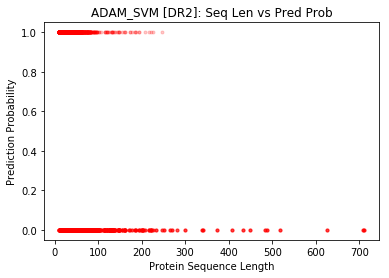

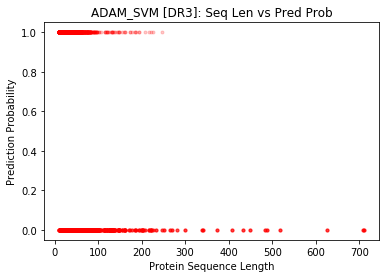

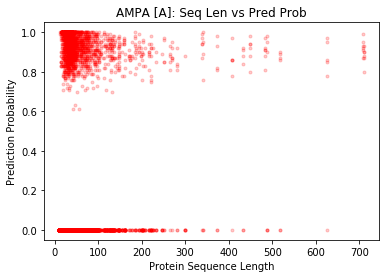

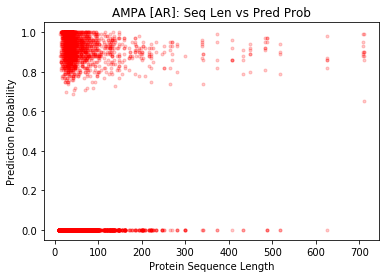

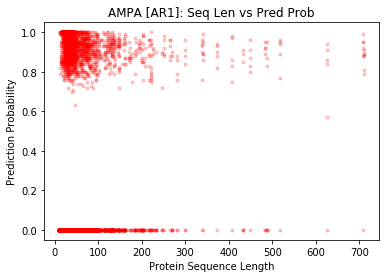

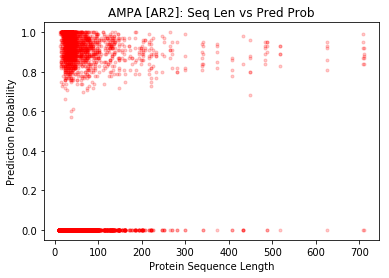

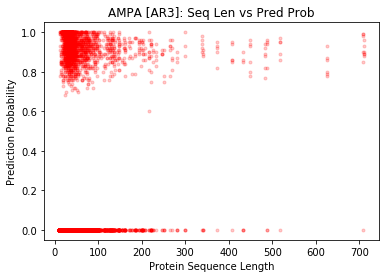

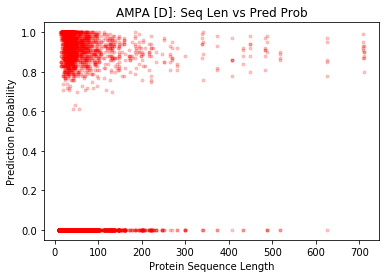

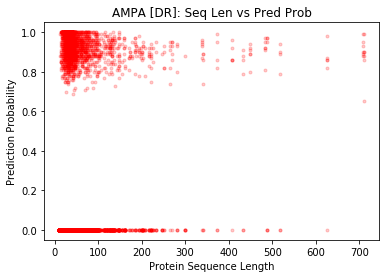

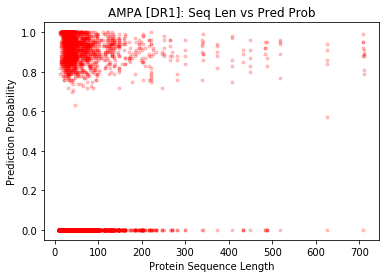

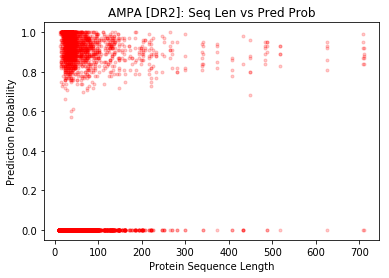

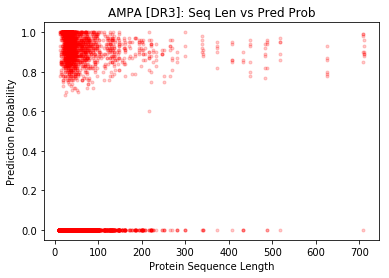

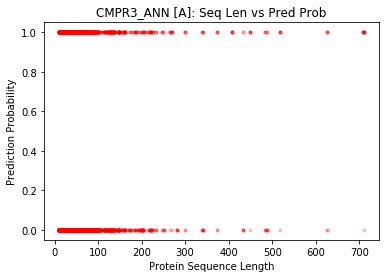

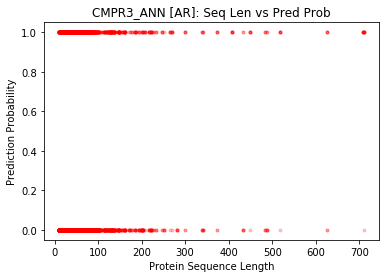

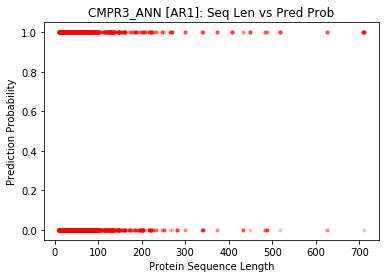

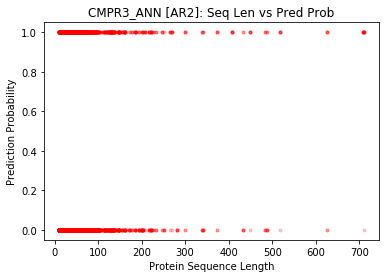

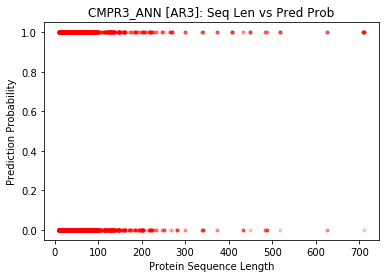

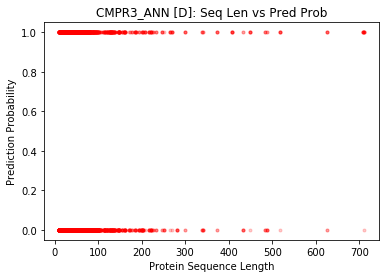

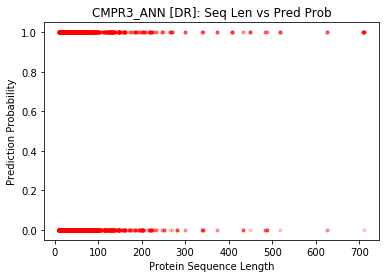

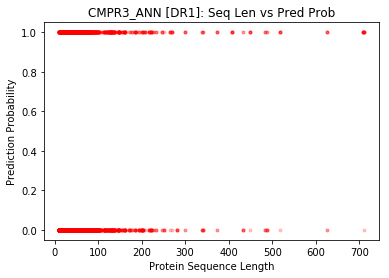

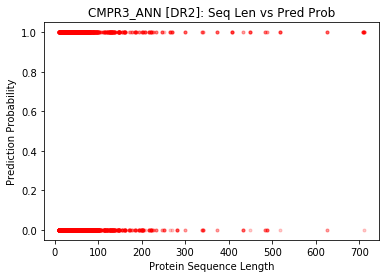

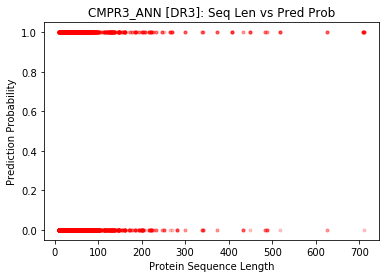

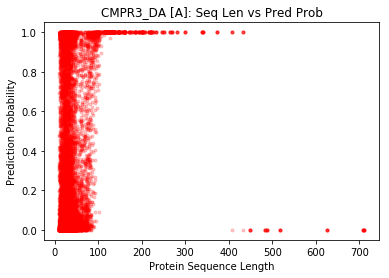

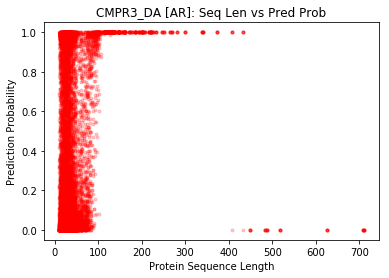

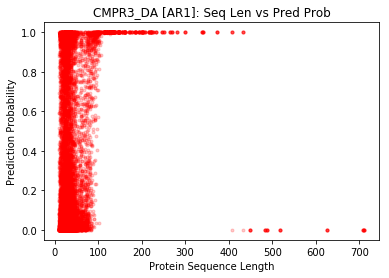

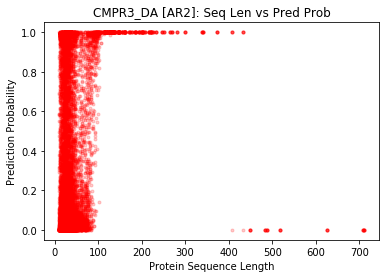

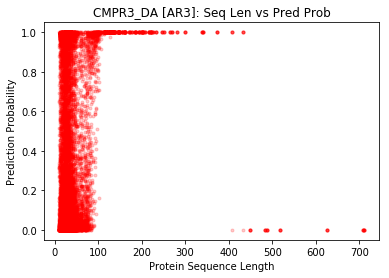

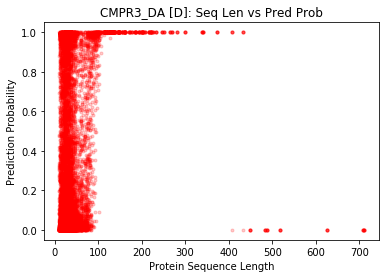

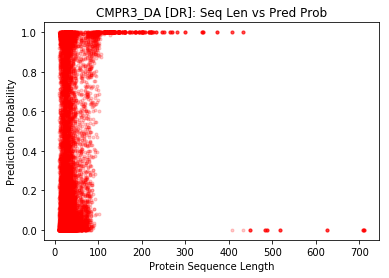

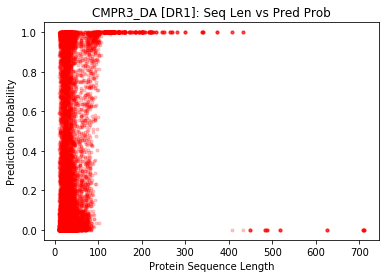

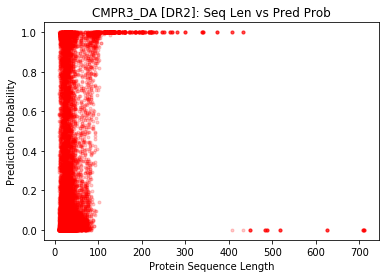

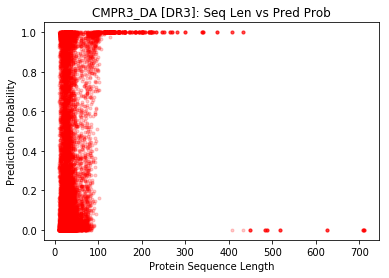

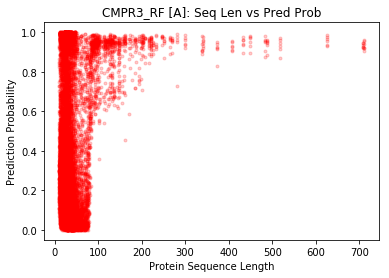

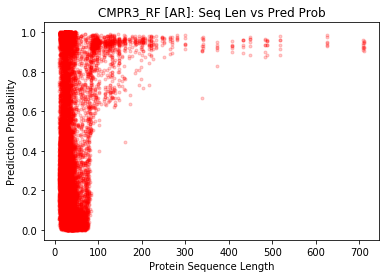

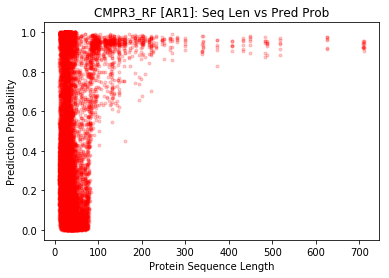

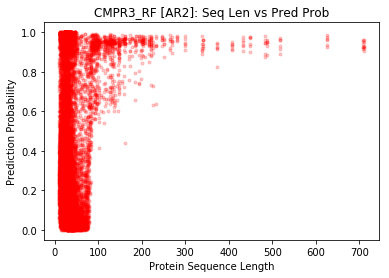

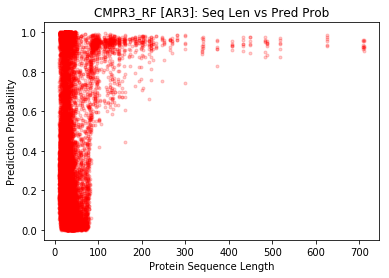

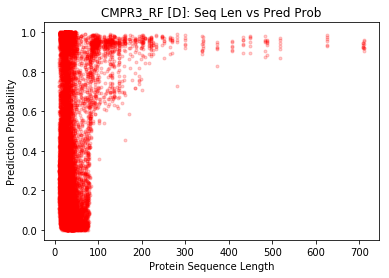

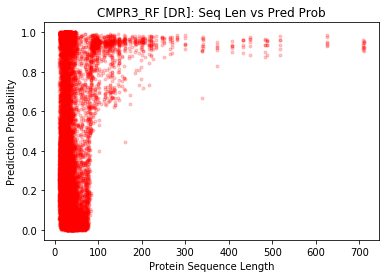

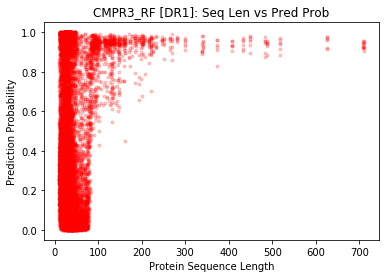

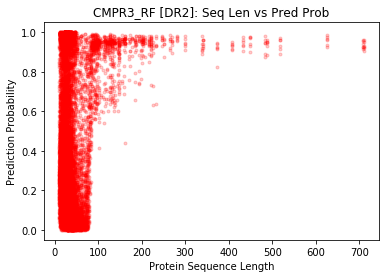

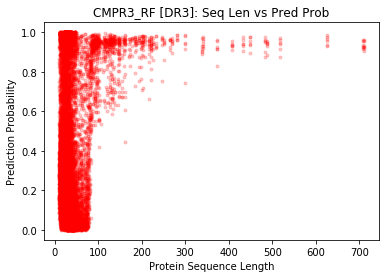

In [13]:
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            plt.title(s + ' ['+d+r+']' + ': Seq Len vs Pred Prob')
            plt.plot(data[s][d][r]['PepSeq'].apply(len), data[s][d][r]['PredScore'], 'r.', alpha=0.2)
            plt.xlabel('Protein Sequence Length')
            plt.ylabel('Prediction Probability')
            plt.show()

### Number of Unique Protein Count vs Prediction Probability

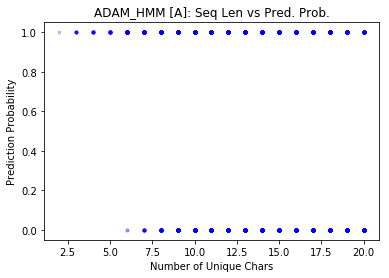

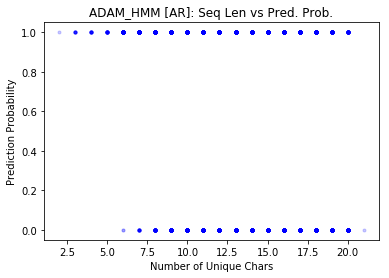

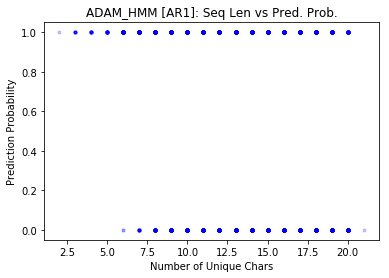

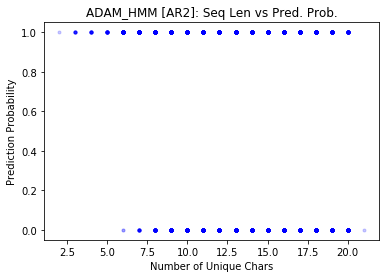

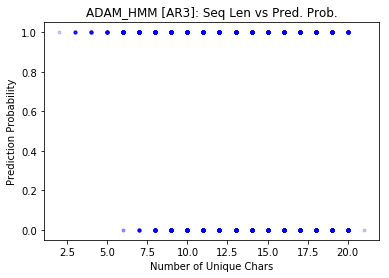

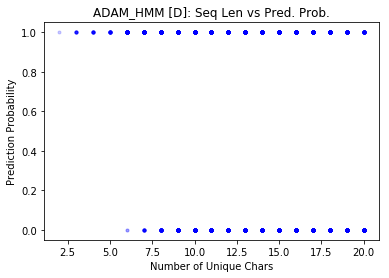

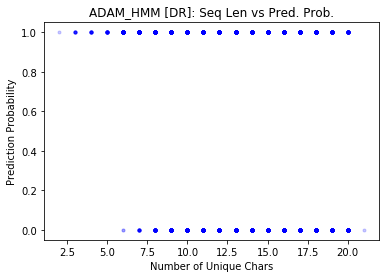

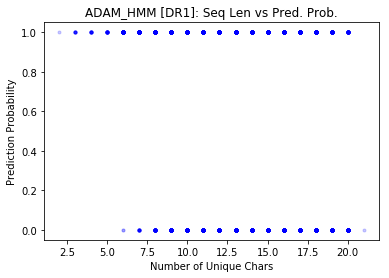

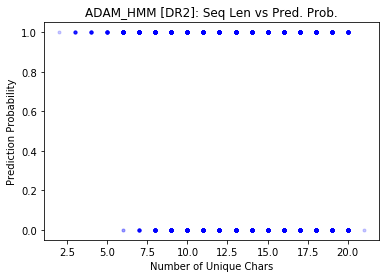

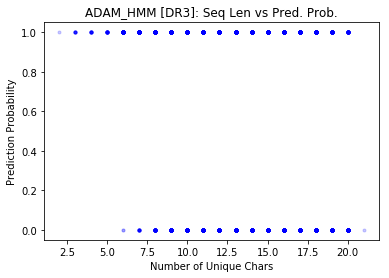

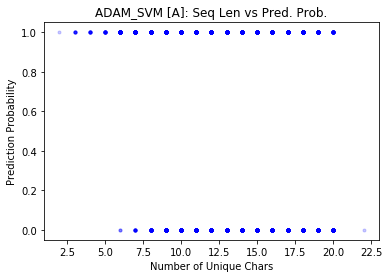

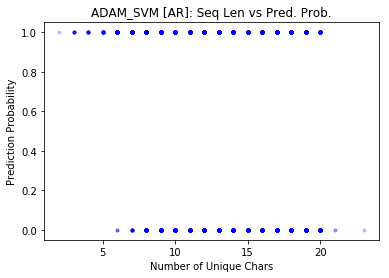

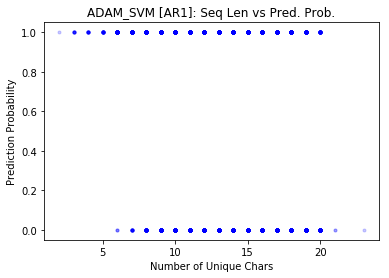

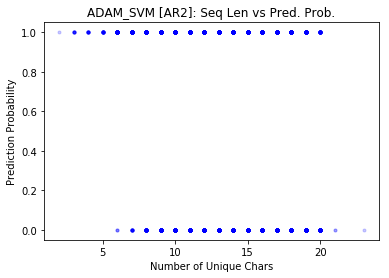

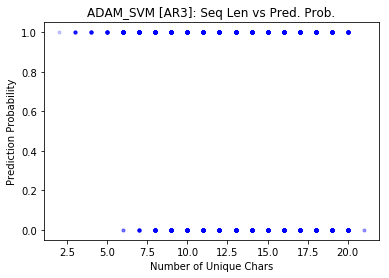

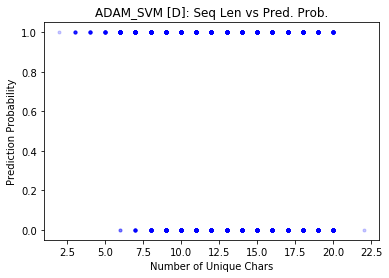

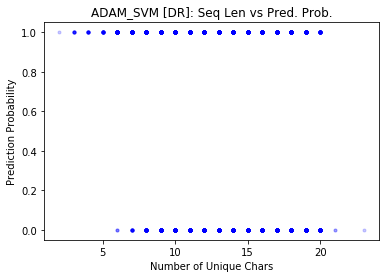

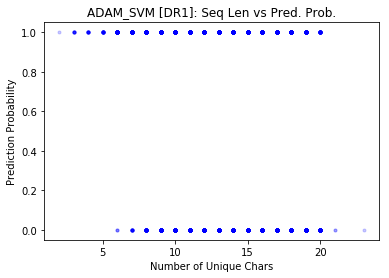

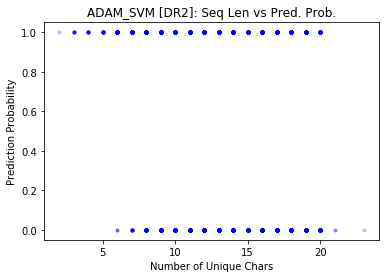

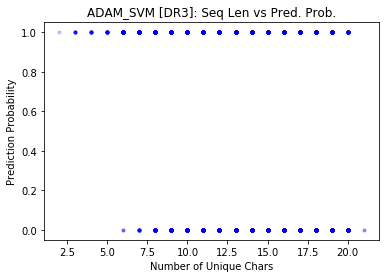

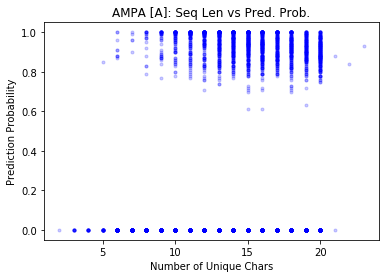

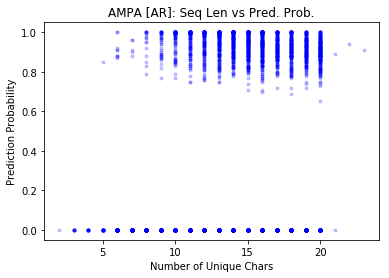

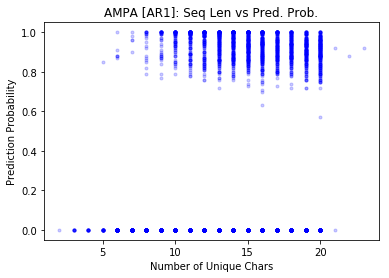

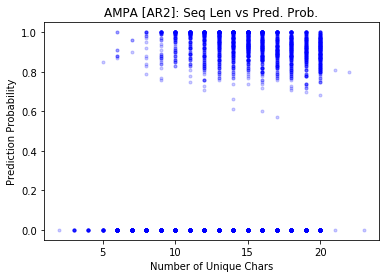

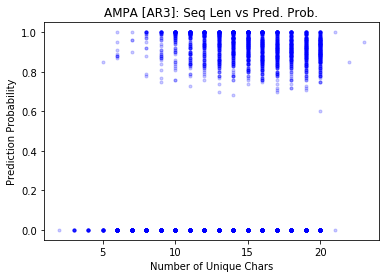

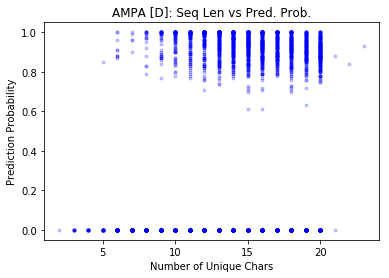

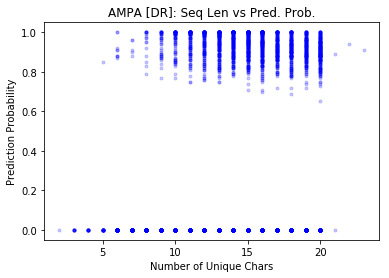

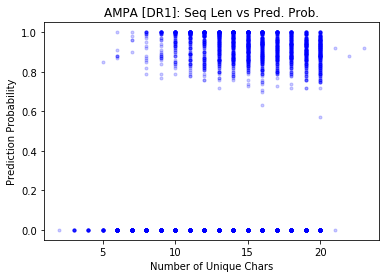

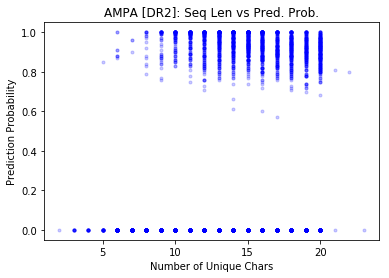

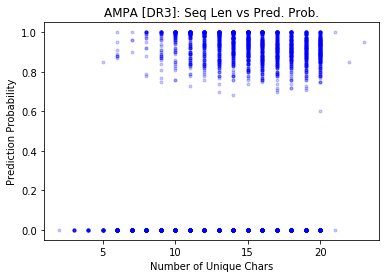

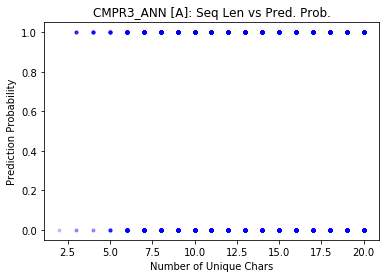

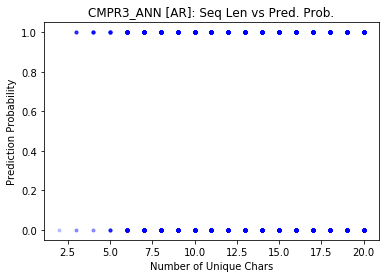

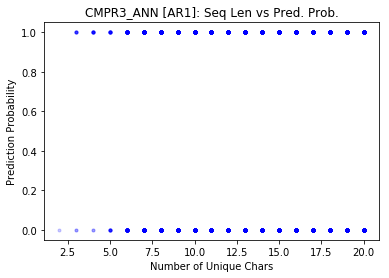

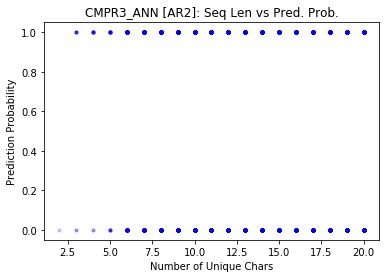

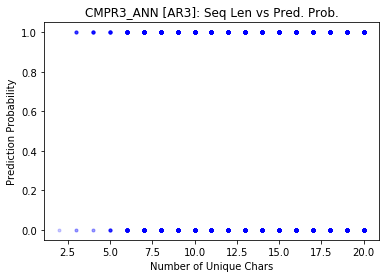

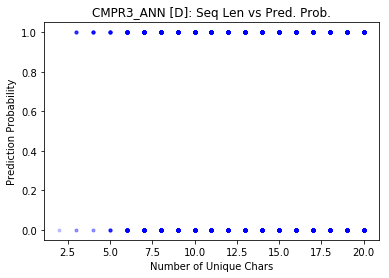

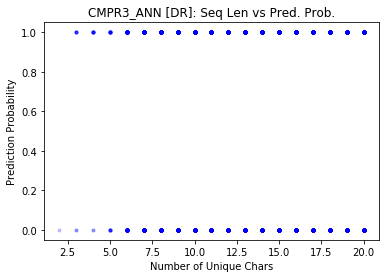

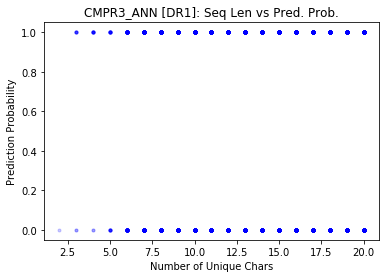

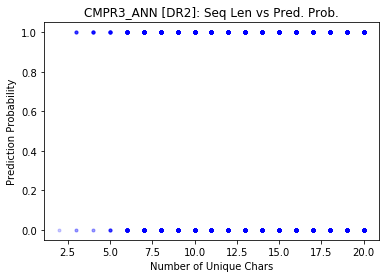

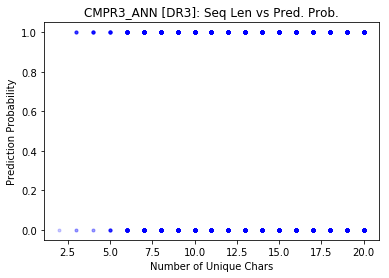

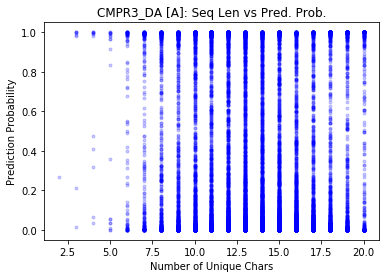

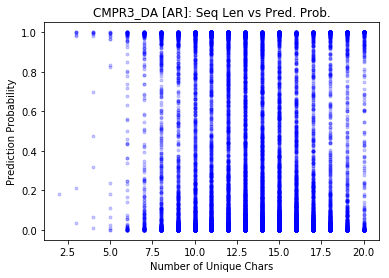

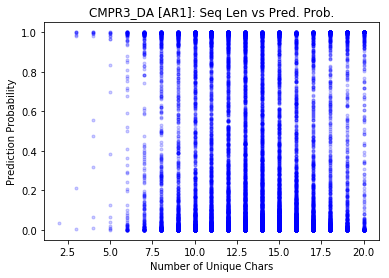

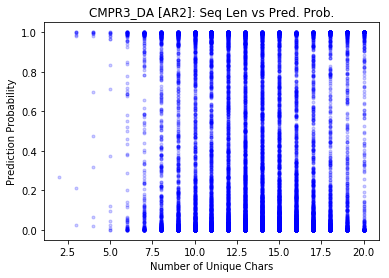

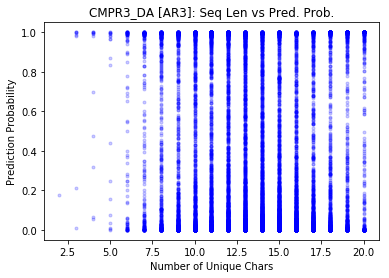

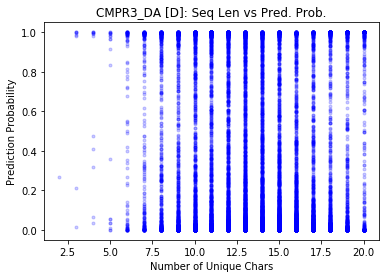

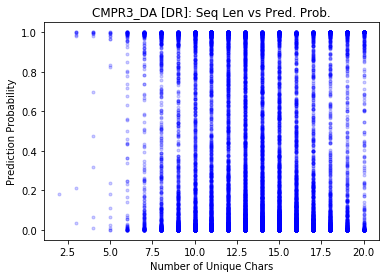

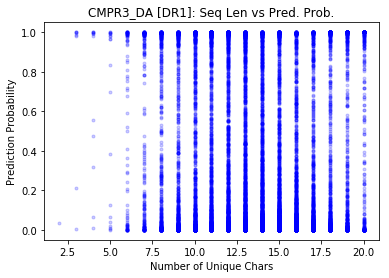

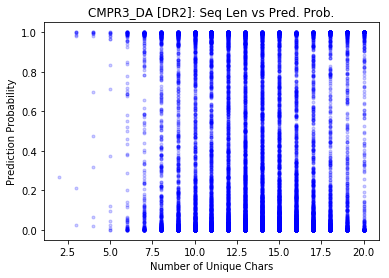

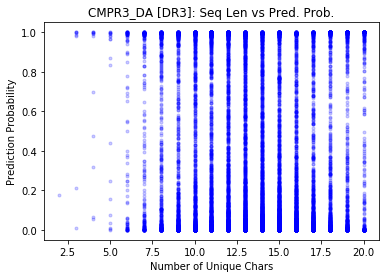

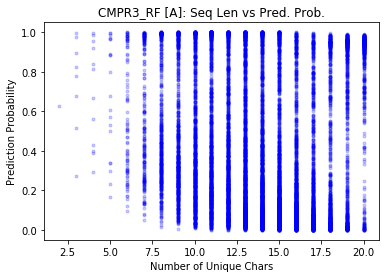

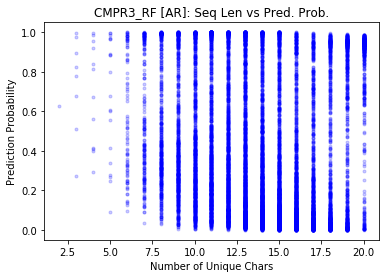

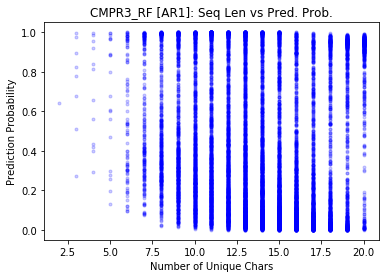

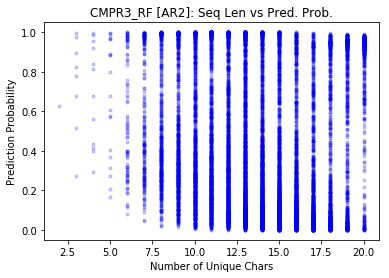

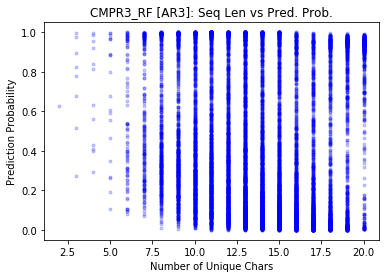

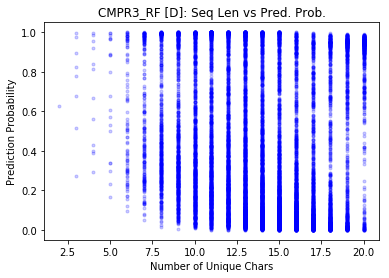

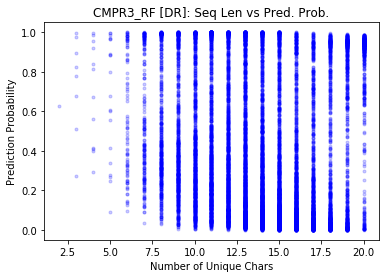

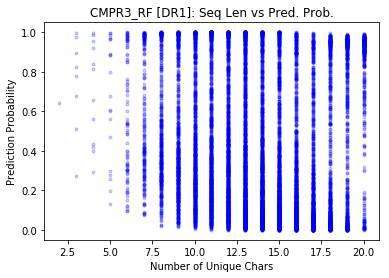

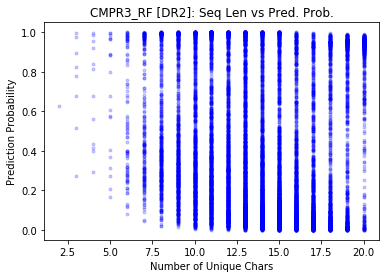

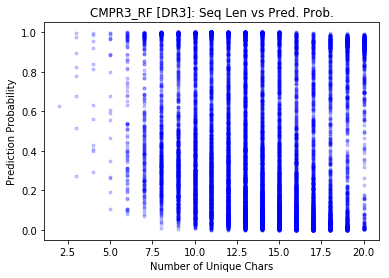

In [14]:
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            plt.title(s + ' ['+d+r+']' + ': Seq Len vs Pred. Prob.')
            plt.plot(data[s][d][r]['PepSeq'].apply(lambda x: len(set(x))), data[s][d][r]['PredScore'], 'b.', alpha=0.2)
            plt.xlabel('Number of Unique Chars')
            plt.ylabel('Prediction Probability')
            plt.show()